In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import ks_2samp

### Loading Starting Moneyline Data

In [38]:
df = pd.read_parquet('s3://moneygans-data/basketball_nba/starting_money/starting_money_agg/starting_money_all.parquet', engine='pyarrow')[['pos_money','neg_money']]
df

,pos_money,neg_money
0,380,-500
1,340,-500
2,400,-550
3,400,-550
4,400,-525
...,...,...
31,400,-520
32,375,-500
33,400,-550
34,340,-450


#### Empirical Starting Moneyline Distribution

/Users/jake/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jake/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


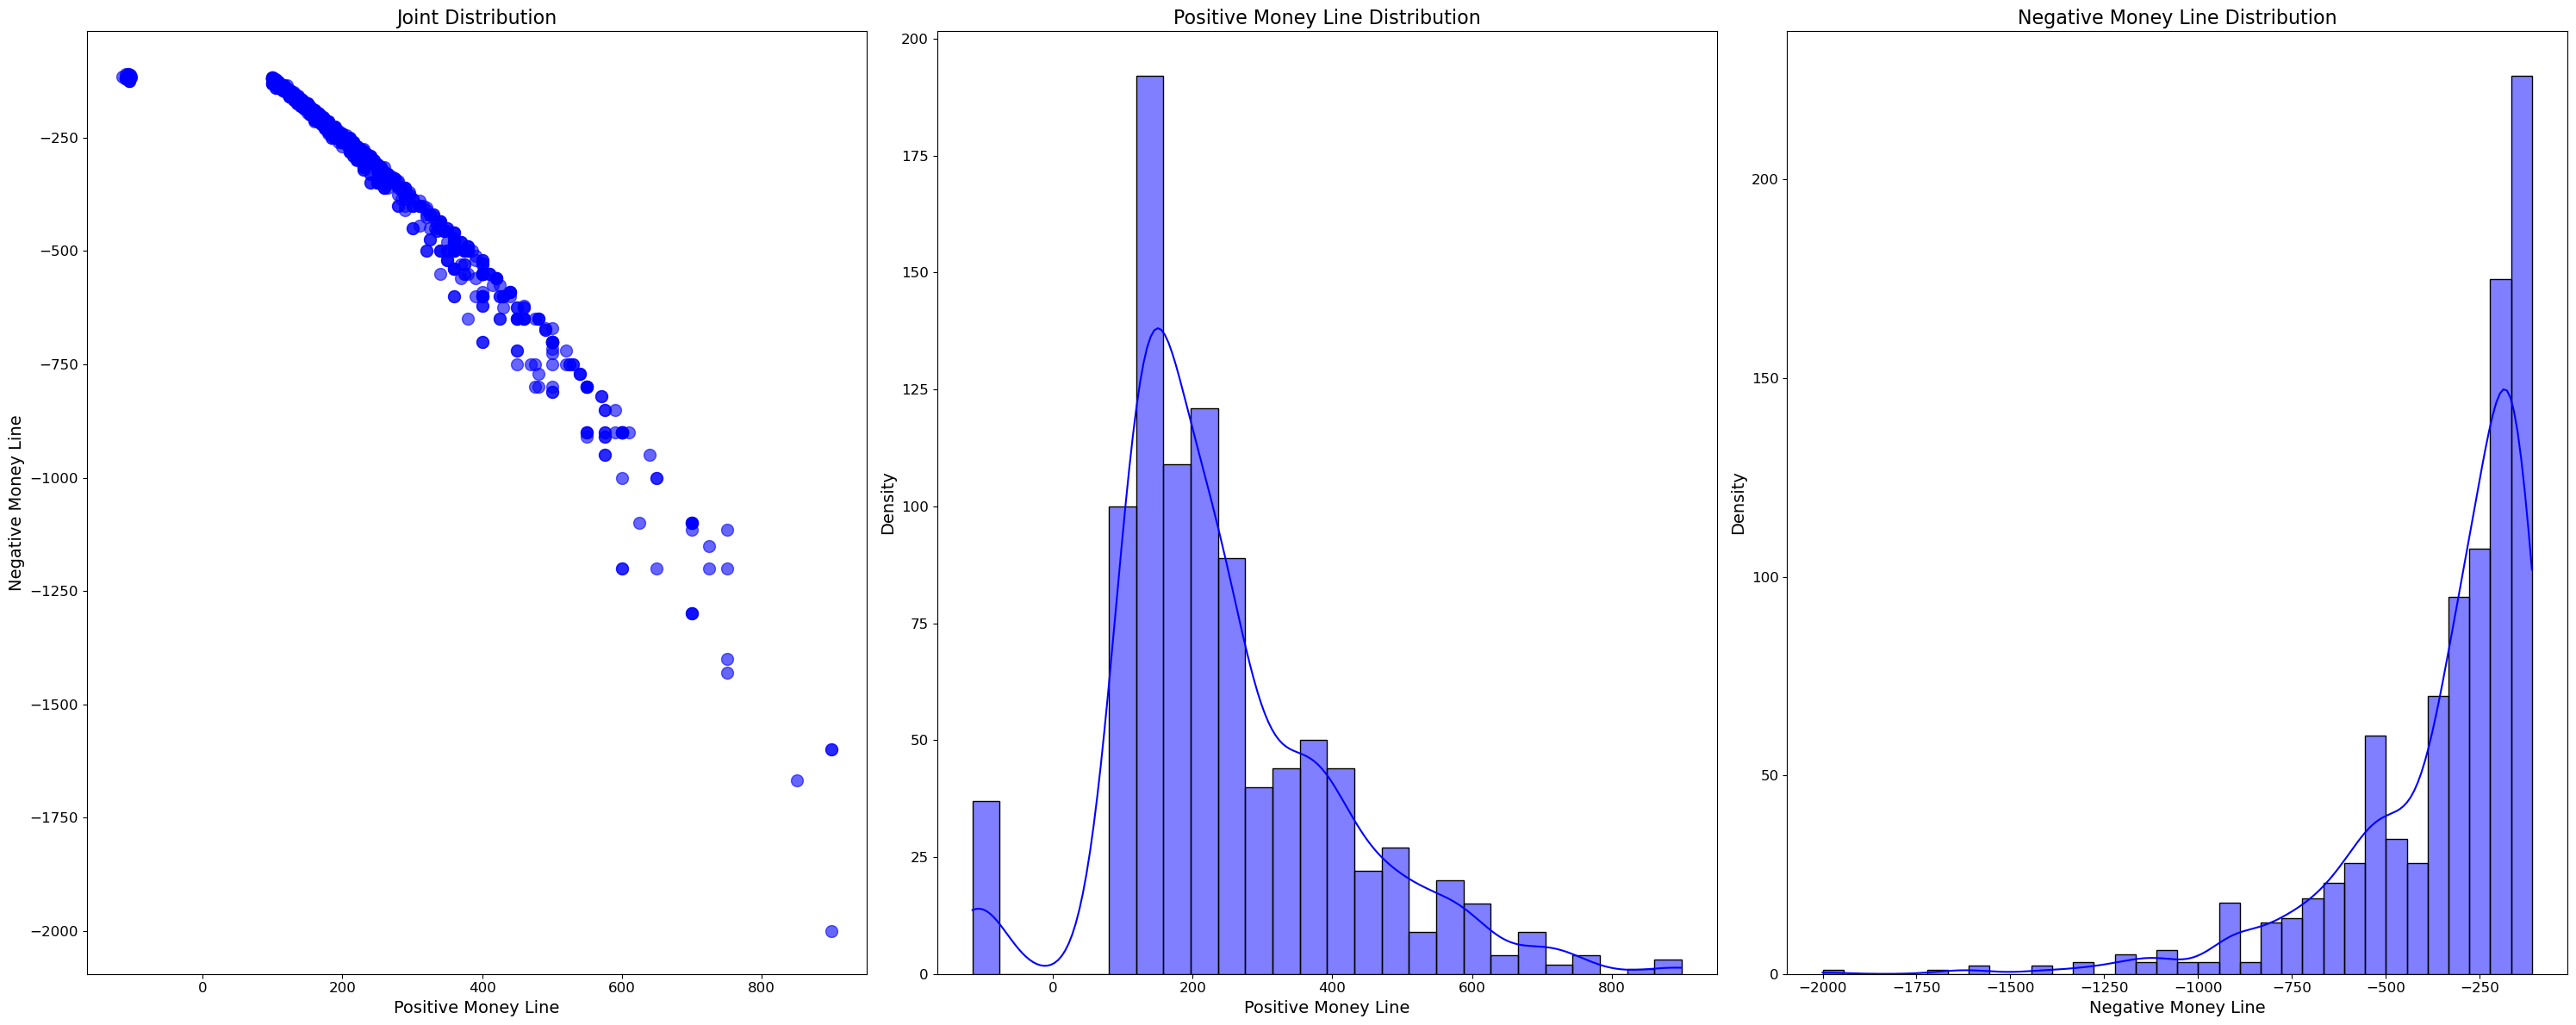

In [39]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 12))

# Joint distribution
ax1.scatter(df['pos_money'], df['neg_money'], color='blue', alpha=0.6, s=100)
ax1.set_title('Joint Distribution', fontsize=16)
ax1.set_xlabel('Positive Money Line', fontsize=14)
ax1.set_ylabel('Negative Money Line', fontsize=14)
ax1.tick_params(axis='both', which='major', labelsize=12)

# Positive moneyline distribution
sns.histplot(df['pos_money'], kde=True, color='blue', ax=ax2)
ax2.set_title('Positive Money Line Distribution', fontsize=16)
ax2.set_xlabel('Positive Money Line', fontsize=14)
ax2.set_ylabel('Density', fontsize=14)
ax2.tick_params(axis='both', which='major', labelsize=12)

# Negative moneyline distribution  
sns.histplot(df['neg_money'], kde=True, color='blue', ax=ax3)
ax3.set_title('Negative Money Line Distribution', fontsize=16)
ax3.set_xlabel('Negative Money Line', fontsize=14)
ax3.set_ylabel('Density', fontsize=14)
ax3.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.show()

##### Converting df to array

In [40]:
data = df.values.astype(np.float32)
data.shape

(942, 2)

## Spectral Normalization, Larger Network with Dropout

In [41]:
# Create a PyTorch dataset and dataloader
# Convert data to PyTorch tensor
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)  # Fit and transform the data first
real_data = torch.tensor(scaled_data)
batch_size = 64  # Adjust batch size as needed
dataset = TensorDataset(real_data)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define the Generator network with Batch Normalization, Dropout, and more layers
class Generator(nn.Module):
    def __init__(self, noise_dim=10, output_dim=2):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, output_dim),
        )

    def forward(self, z):
        return self.model(z)

# Define the Critic network with Spectral Normalization, Dropout, and more layers
class Critic(nn.Module):
    def __init__(self, input_dim=2):
        super(Critic, self).__init__()
        self.model = nn.Sequential(
            nn.utils.spectral_norm(nn.Linear(input_dim, 256)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.utils.spectral_norm(nn.Linear(256, 512)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.utils.spectral_norm(nn.Linear(512, 256)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.utils.spectral_norm(nn.Linear(256, 1)),
        )

    def forward(self, x):
        return self.model(x)

# Hyperparameters
noise_dim = 10
n_epochs = 5000  # Increase epochs for better results
lr = 1e-4
n_critic = 5  # Number of critic iterations per generator iteration

# Initialize models and optimizers
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
if device.type == 'cuda':
    print("GPU:", torch.cuda.get_device_name(0))
G = Generator(noise_dim=noise_dim, output_dim=2).to(device)
C = Critic(input_dim=2).to(device)

optimizer_G = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.9))
optimizer_C = optim.Adam(C.parameters(), lr=lr, betas=(0.5, 0.9))

# Lists to store loss values for visualization
losses_G = []
losses_C = []

# Training loop
for epoch in range(1, n_epochs + 1):
    for i, data_batch in enumerate(dataloader):
        real_samples = data_batch[0].to(device)
        batch_size = real_samples.size(0)

        # Train Critic
        for _ in range(n_critic):
            z = torch.randn(batch_size, noise_dim).to(device)
            fake_samples = G(z).detach()

            critic_real = C(real_samples)
            critic_fake = C(fake_samples)

            loss_C = -(torch.mean(critic_real) - torch.mean(critic_fake))

            optimizer_C.zero_grad()
            loss_C.backward()
            optimizer_C.step()

        # Train Generator
        z = torch.randn(batch_size, noise_dim).to(device)
        fake_samples = G(z)
        critic_fake = C(fake_samples)
        loss_G = -torch.mean(critic_fake)

        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()

    # Store losses for plotting
    losses_G.append(loss_G.item())
    losses_C.append(loss_C.item())

    if epoch % 100 == 0 or epoch == 1:
        print(f"Epoch {epoch}, Loss C: {loss_C.item():.4f}, Loss G: {loss_G.item():.4f}")

# Generate synthetic data
with torch.no_grad():
    z = torch.randn(len(real_data), noise_dim).to(device)
    generated_samples = G(z).cpu().numpy()

# Inverse transform the data if normalized
generated_samples = scaler.inverse_transform(generated_samples)
real_data_np = scaler.inverse_transform(real_data.numpy())

# Convert to DataFrames for easier plotting
real_df = pd.DataFrame(real_data_np, columns=['pos_money', 'neg_money'])
gen_df = pd.DataFrame(generated_samples, columns=['pos_money', 'neg_money'])


Using device: cpu
Epoch 1, Loss C: -0.6459, Loss G: -0.1902
Epoch 100, Loss C: -0.0324, Loss G: -0.0532
Epoch 200, Loss C: -0.0576, Loss G: -0.3275
Epoch 300, Loss C: 0.0133, Loss G: -0.2579
Epoch 400, Loss C: -0.0227, Loss G: -0.3583
Epoch 500, Loss C: 0.0015, Loss G: -0.3120
Epoch 600, Loss C: 0.0111, Loss G: -0.3502
Epoch 700, Loss C: -0.0102, Loss G: -0.3337
Epoch 800, Loss C: 0.0263, Loss G: -0.4490
Epoch 900, Loss C: 0.0065, Loss G: -0.4249
Epoch 1000, Loss C: 0.0078, Loss G: -0.2936
Epoch 1100, Loss C: -0.0022, Loss G: -0.3464
Epoch 1200, Loss C: -0.0035, Loss G: -0.3647
Epoch 1300, Loss C: -0.0015, Loss G: -0.3496
Epoch 1400, Loss C: -0.0056, Loss G: -0.3567
Epoch 1500, Loss C: -0.0096, Loss G: -0.3579
Epoch 1600, Loss C: -0.0070, Loss G: -0.3971
Epoch 1700, Loss C: -0.0004, Loss G: -0.4483
Epoch 1800, Loss C: 0.0055, Loss G: -0.5328
Epoch 1900, Loss C: -0.0136, Loss G: -0.4142
Epoch 2000, Loss C: -0.0268, Loss G: -0.3837
Epoch 2100, Loss C: 0.0476, Loss G: -0.5101
Epoch 2200, 

In [45]:
gen_df.to_csv("../experiments/WGAN_Final_Gen_Data.csv")

In [46]:
def plot_real_vs_generated(real_df, gen_df):
    """
    Creates a scatter plot comparing real and generated data points.
    
    Args:
        real_df (DataFrame): DataFrame containing real data
        gen_df (DataFrame): DataFrame containing generated data
    """
    plt.figure(figsize=(10, 7))
    plt.scatter(real_df['pos_money'], real_df['neg_money'], label='Real Data', color='blue', alpha=0.6)
    plt.scatter(gen_df['pos_money'], gen_df['neg_money'], label='Generated Data', color='orange', alpha=0.6)
    plt.title('Real Data vs. Generated Data')
    plt.xlabel('Positive Money Line')
    plt.ylabel('Negative Money Line')
    plt.legend()
    plt.show()

def plot_training_losses(losses_G, losses_C):
    """
    Plots the training losses for both Generator and Critic over epochs.
    
    Args:
        losses_G (list): List of Generator losses
        losses_C (list): List of Critic losses
    """
    plt.figure(figsize=(10, 5))
    plt.plot(losses_G, label='Generator Loss')
    plt.plot(losses_C, label='Critic Loss')
    plt.title('Generator and Critic Losses During Training')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_feature_distributions(real_df, gen_df):
    """
    Creates histograms comparing the distribution of features between real and generated data.
    
    Args:
        real_df (DataFrame): DataFrame containing real data
        gen_df (DataFrame): DataFrame containing generated data
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    sns.histplot(real_df['pos_money'], kde=True, color='blue', label='Real', ax=axes[0])
    sns.histplot(gen_df['pos_money'], kde=True, color='orange', label='Generated', ax=axes[0])
    axes[0].set_title('Distribution of Positive Money Line')
    axes[0].legend()

    sns.histplot(real_df['neg_money'], kde=True, color='blue', label='Real', ax=axes[1])
    sns.histplot(gen_df['neg_money'], kde=True, color='orange', label='Generated', ax=axes[1])
    axes[1].set_title('Distribution of Negative Money Line')
    axes[1].legend()
    plt.show()

def plot_joint_kde(real_df, gen_df):
    """
    Creates a kernel density estimation plot for the joint distribution of features.
    
    Args:
        real_df (DataFrame): DataFrame containing real data
        gen_df (DataFrame): DataFrame containing generated data
    """
    plt.figure(figsize=(10, 7))
    sns.kdeplot(data=real_df, x='pos_money', y='neg_money', cmap='Blues', fill=True, thresh=0, levels=10, label='Real Data')
    sns.kdeplot(data=gen_df, x='pos_money', y='neg_money', cmap='Oranges', fill=True, thresh=0, levels=10, label='Generated Data')
    plt.title('KDE of Real vs. Generated Data')
    plt.xlabel('Positive Money Line')
    plt.ylabel('Negative Money Line')
    plt.legend()
    plt.show()

def plot_2d_histogram(real_df, gen_df):
    """
    Creates a 2D histogram (hexbin plot) comparing real and generated data distributions.
    
    Args:
        real_df (DataFrame): DataFrame containing real data
        gen_df (DataFrame): DataFrame containing generated data
    """
    plt.figure(figsize=(10, 7))
    plt.hexbin(real_df['pos_money'], real_df['neg_money'], gridsize=30, cmap='Blues', alpha=0.5)
    plt.hexbin(gen_df['pos_money'], gen_df['neg_money'], gridsize=30, cmap='Oranges', alpha=0.5)
    plt.title('2D Histogram of Real and Generated Data')
    plt.xlabel('Positive Money Line')
    plt.ylabel('Negative Money Line')
    plt.colorbar(label='Counts')
    plt.show()

def perform_ks_test(real_df, gen_df):
    """
    Performs Kolmogorov-Smirnov test to compare real and generated distributions.
    
    Args:
        real_df (DataFrame): DataFrame containing real data
        gen_df (DataFrame): DataFrame containing generated data
    """
    ks_stat_pos, p_value_pos = ks_2samp(real_df['pos_money'], gen_df['pos_money'])
    ks_stat_neg, p_value_neg = ks_2samp(real_df['neg_money'], gen_df['neg_money'])
    
    print(f"KS Test for 'pos_money': KS Statistic = {ks_stat_pos:.4f}, p-value = {p_value_pos:.4f}")
    print(f"KS Test for 'neg_money': KS Statistic = {ks_stat_neg:.4f}, p-value = {p_value_neg:.4f}")



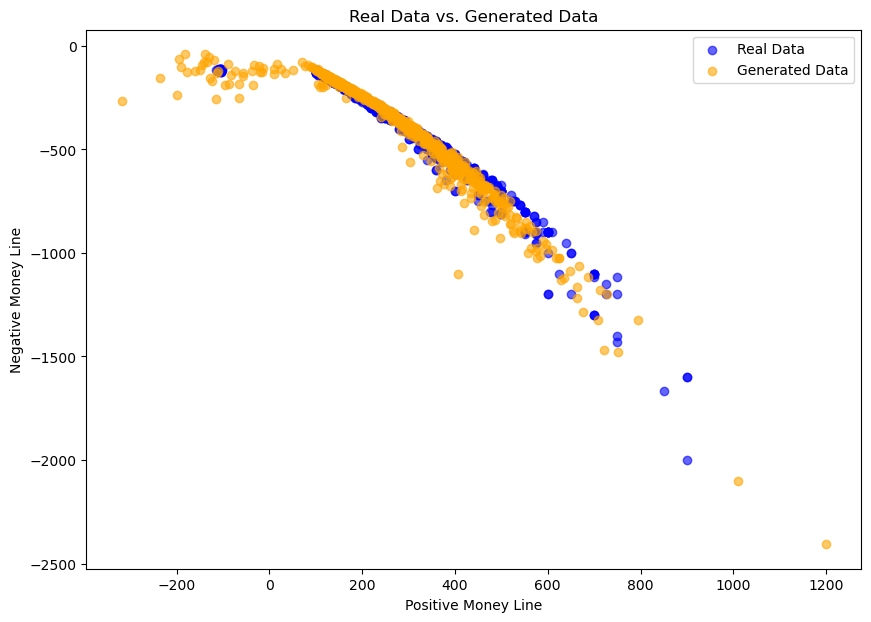

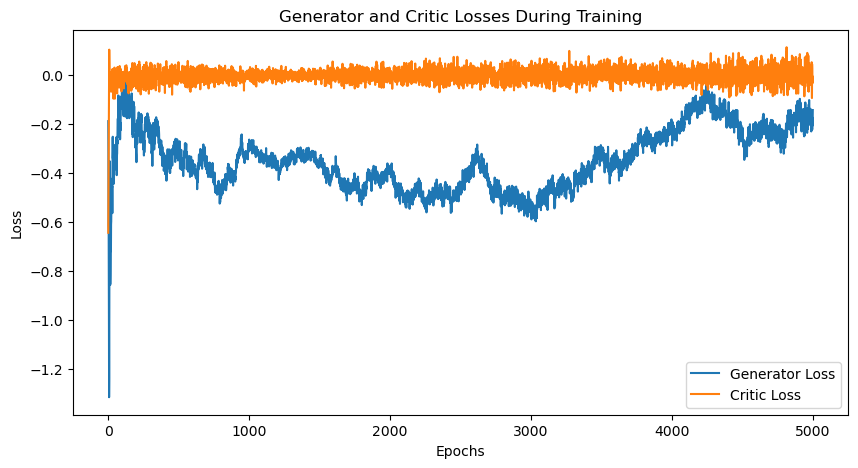

/Users/jake/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jake/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jake/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jake/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

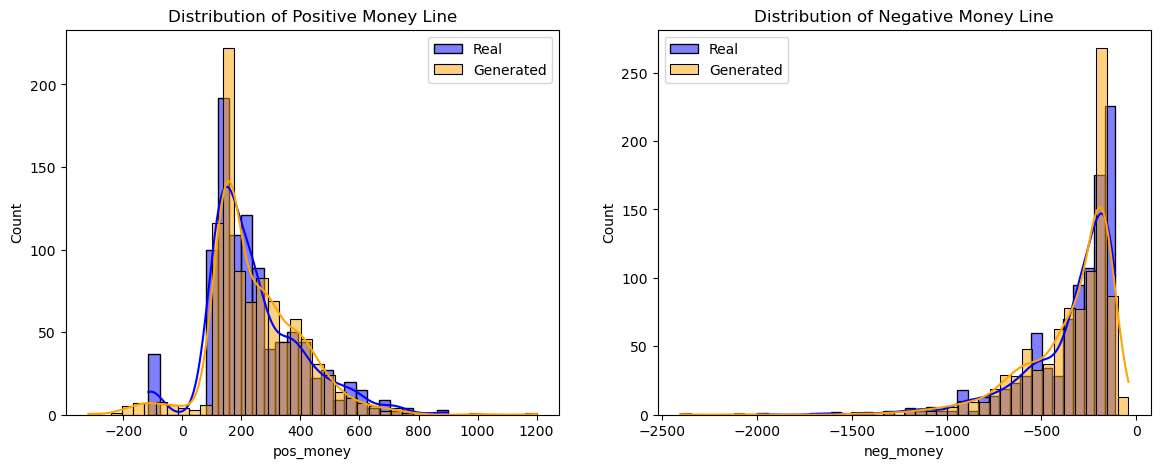

/Users/jake/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jake/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jake/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jake/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

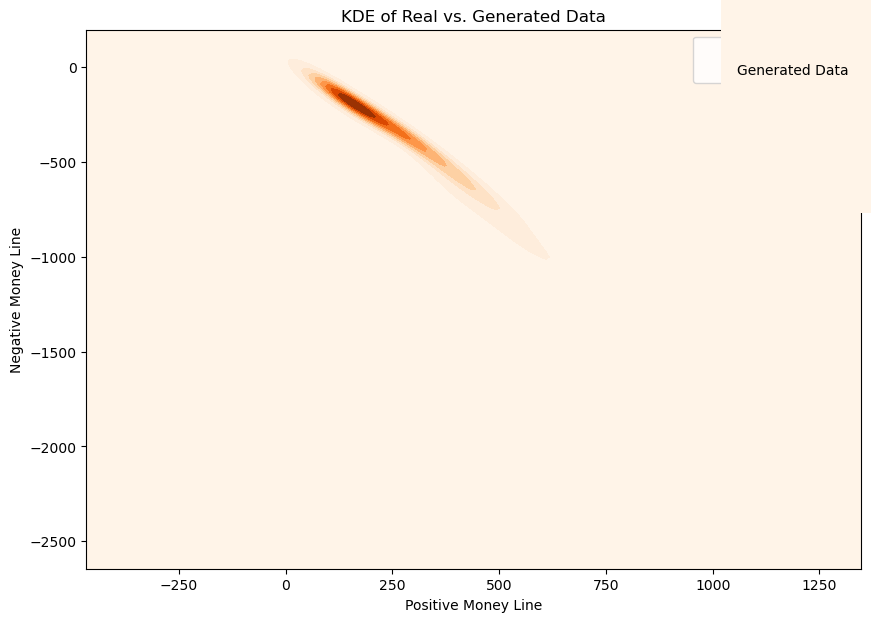

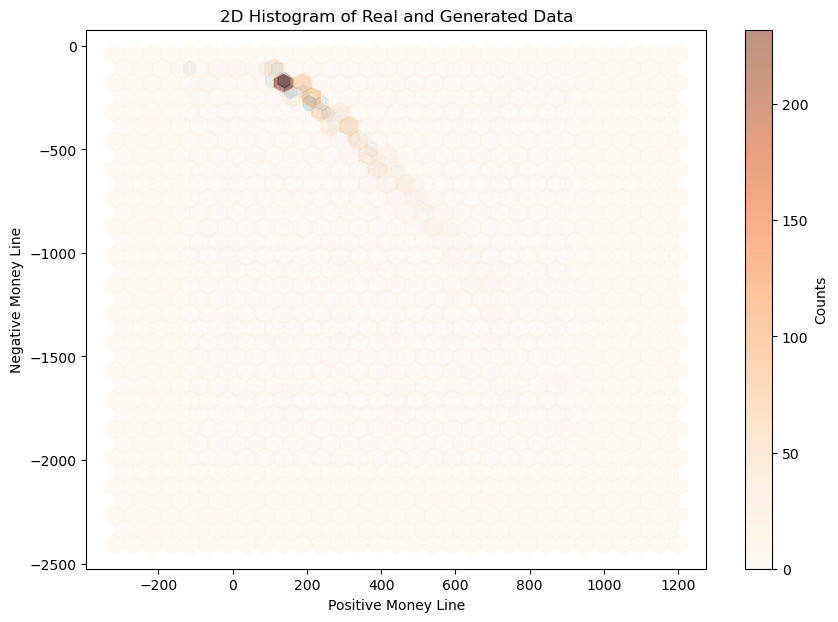

KS Test for 'pos_money': KS Statistic = 0.0987, p-value = 0.0002
KS Test for 'neg_money': KS Statistic = 0.0934, p-value = 0.0005


In [47]:
# Call all visualization and analysis functions
plot_real_vs_generated(real_df, gen_df)
plot_training_losses(losses_G, losses_C)
plot_feature_distributions(real_df, gen_df)
plot_joint_kde(real_df, gen_df)
plot_2d_histogram(real_df, gen_df)
perform_ks_test(real_df, gen_df)